In [1]:
##Libraries
from calendar import monthrange
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from obspy.geodetics.base import gps2dist_azimuth
from datetime import datetime
import pandas as pd
from math import radians, log

##Own librairies
from read_hs_p2l import read_WWNC, read_WWNCf
from rayleigh_functions import loop_azimuthal, site_effect
from readWW31 import read_dpt

__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2022, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "1.2"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Production"

# Rayleigh Source of microseisms

This program aims at modelizing the ambient noise source in the secondary microseismic range for Rayleigh waves.
It is based on Ardhuin et al. (2011) article.

## Power Spectrum of the Vertical Displacement
We will compute the **equivalent source for the power spectrum of the vertical displacement** $S_{DF}$, its unit is meter times seconds.
$$ S_{DF}(f_s) \approx \frac{2\pi f_s C}{\rho_s^2 \beta^5} F_{p3D}(k_2 \approx 0, f_s)$$ 
where:
- $f_s$ is the seismic frequency (twice the ocean wave frequency)
- C is the amplitude response functions for the normal modes, from Longuet-Higgins (1950). $C = \sum_{i=1}^{4} c_i^2$
- $\rho_s$ is the rock density of the crust. Here $\rho_s = 2830 kg.m^{-3}$
- $\beta$ is the shear wave velocity. Here $\beta = 2.8 km.s^{-1}$
- $F_{p3D}(k_2 \approx 0, f_s)$ the spectral density of the pressure field at the ocean surface or directional wave spectra.

In our case Rayleigh waves are dominant in the periodic band from 5s to 12s so we will integrate this over the corresponding frequency band.
$$ S_{DF} = \int_{0.083}^{0.200} S_{DF}(f)  df $$

The values of the Rayleigh waves site effect coefficient can be found in Longuet-Higgins (1950), the values are tabulated in longuet_higgins.txt file.
The $F_{p3D}$ can be retrieved using oceanic waves model resources from the Ifremer institute in Brest, France.

## Power Spectrum of the Vertical Ground Displacement at a given seismic station

From the global noise source $S_{DF}(f)$, we will compute the power spectrum of the vertical ground displacement $F_{\delta}(\lambda, \phi, f)$ at a station of latitude $\lambda$ and longitude $\phi$. This value is frequency dependent so we will use the unintegrated $S_{DF}(f)$ value and display integrated $ F_{\delta}$. Some strong hypothesis on the propagation of Rayleigh waves between the source and the given station: 
- vertically symmetric earth model
- no 3D propagation effect
- uniform Q

The value of Q is a parameter, however some tabulated values are available.
$$ F_{\delta}(\lambda, \phi, fs) = \int_{\lambda_m}^{\lambda_{m+1}} \int_{\phi_n}^{\phi_{n+1}} \frac{S_{DF}(f)}{R_E \sin\Delta} e^{\frac{-2\pi f \Delta R_E}{UQ}} R_E^2 \sin \phi' d\lambda' d\phi' $$
where:
- $\lambda$ is the latitude of the station
- $\phi$ is the longitude of the station
- $R_E$ is the Earth radius
- U is the seismic group velocity. Here $U = 1.8 km.s^{-1}$
- Q is the attenuation factor. It varies with location, we give some examples in the code.
- $\Delta$ is the distance of the point integrated to the station.

For convenience we represent the integrated value of $F_{\delta}$ over frequency:
$$ F_\delta (\lambda, \phi) = \int_{fs = 0.083}^{0.200} F_\delta (\lambda, \phi, f) df$$

The $(\lambda_m)_{m \in \mathbb{N}}$ and $(\phi_n)_{n \in \mathbb{N}}$ series are used to slice integration domain, especially get the azimuthal contribution to $F_\delta$.



References: 
* Ardhuin, F., Stutzmann, E., Schimmel, M., & Mangeney, A. (2011). Ocean wave sources of seismic noise. Journal of Geophysical Research: Oceans, 116(C9).
* Longuet-Higgins, M. S. (1950). A theory of the origin of microseisms. Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences, 243(857), 1-35.

In [2]:
## Set font size parameters to make readable figures
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Parameters
This implementation is depending on a few parameters. Some are described above in the formula of our rayleigh wave noise source but others are for the user to choose.

The first set of parameters is the physical constants above. The plot variable allows you to plot monthly source or not. For particular events set to False. Then the dates the user wants to focus on, loops on hours, days, months and years are available setting an empty bracket symbol.

Then the different paths for the bathymetry files, Longuet-Higgins values of site effect file, files from the WW3 Hindcast data wave model. For the model files go to ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/, then choose the year(s) and month(s) corresponding files. Two files are necessary, the significant waveheight file, extension hs.nc and the directional wave spectra file, extension p2l.nc. Finally the user can choose the extent of the maps with minimum and maximum longitudes and latitudes.

In [3]:
"""Parameters for ocean site effect maps """

# seismic waves
vs_crust = 2.8  # km/s
rho_s = 2830  # kg/m3
f1 = 1/12  # frequency to integrate from
f2 = 1/5  # frequency to integrate to
res_mod = radians(0.5)  # angular resolution of the model
radius = 6.371*1e6
lg10 = log(10)
plot = False # plot PSD integrated over frequency

# dates
YEAR = 2020   # loop if vector
MONTH = [9]  # loop if vector
DAY =  [17]   # loop if vector, compute all days of the month if empty
HOUR = []  # loop if vector

# ww3 file
file_bathy = "ww3.07121700.dpt"
fpath = '/Users/tomasetl/Documents/code/ocean_source/data/2020/'
# site effect file
path = './longuet_higgins.txt'

# extent
lat_min = -90
lat_max = 90
lon_min = -180
lon_max = 180

# azimuthal distribution
U = 1800  # seismic group velocity m/s
Q = {'KIP': 580, 'BORG': 180, 'BKS': 88, 'SSB': 260}
#attenuation factor used in Ardhuin et al. (2011) for 
#KIP (Hawaii) few reflections old crust,
#BORG (Iceland) few reflection young crust,
#BKS (California USA),
#SSB (France)

key = 'SSB'  # determines the Q value

# Station coordinates
lat_sta, lon_sta = 45, 10

# Spatial integration slicing
dist_step = 10  # degrees
azimuth_step = 10  # degrees

### Bathymetry and geometrical properties

In [4]:
[zlat, zlon, dpt1, var] = read_dpt(file_bathy) # Bathymetry file vectors and matrix

ind_lat = np.squeeze(np.argwhere((zlat > lat_min)&(zlat < lat_max)))  # Set latitude extent
ind_lon = np.squeeze(np.argwhere((zlon > lon_min)&(zlon < lon_max)))  # Set longitude extent
ny, nx = len(ind_lat), len(ind_lon)
X, Y = np.meshgrid(zlon, zlat, indexing='xy')  # grid

## Initialise distance to station, azimuth and back-azimuth vectors
distance_in_meters = np.empty((len(zlat), len(zlon)))
distance = np.empty((len(zlat), len(zlon)))
az = np.empty((len(zlat), len(zlon)))
baz = np.empty((len(zlat), len(zlon)))


## Initialize spatial domain for integration 
dist = np.arange(0, 180, dist_step)
azimuth = np.arange(0, 360, azimuth_step)
index_az = np.empty((len(zlat), len(zlon)))
index_dist = np.empty((len(zlat), len(zlon)))

## Geometrical properties
for i in range(len(zlat)):
    for j in range(len(zlon)):
        distance_in_meters[i,j], az[i,j], baz[i,j] = gps2dist_azimuth(lat_sta, lon_sta, Y[i,j], X[i, j])
        distance[i, j] = distance_in_meters[i,j]*180/(np.pi*radius)
        index_dist[i, j] = np.argmin(abs(dist-distance[ i, j]))
        index_az[i, j] = np.argmin(abs(azimuth-az[ i, j]))
        

## Attenuation Factor
Qsta = Q[key]

### Loop over dates

In [5]:
L =  loop_azimuthal(YEAR, MONTH, DAY, HOUR, fpath, path, f1, f2, vs_crust, rho_s, U, Qsta, res_mod, radius, lg10, dist, distance, azimuth, dpt1, X,ind_lat, ind_lon, index_az, index_dist, plot)

/Users/tomasetl/Documents/code/ocean_source/data/2020/WW3-GLOB-30M_202009_p2l.nc
log10(Pa2 m2 s+1E-12)
MAT


/Users/tomasetl/Documents/code/ocean_source/pr_oceanswell/rayleigh/rayleigh_functions.py:174: RuntimeWarning: divide by zero encountered in true_divide
  denominateur = 1/(radius*np.sin(np.radians(distance)))


log10(Pa2 m2 s+1E-12)
MAT
log10(Pa2 m2 s+1E-12)
MAT
log10(Pa2 m2 s+1E-12)
MAT
log10(Pa2 m2 s+1E-12)
MAT
log10(Pa2 m2 s+1E-12)
MAT
log10(Pa2 m2 s+1E-12)
MAT
log10(Pa2 m2 s+1E-12)
MAT


### Get data and organize it for plot of azimuth contribution as a function of time.

In [6]:
df = pd.DataFrame(L)
print(df.keys())

DATE = df['date'].to_numpy()
T = len(DATE)
A = len(azimuth)
print(A)
azi = np.empty((T, A))
AZ = df['AZ'].to_numpy()
print(AZ)

for i in range(T):
    azi[i,:] = AZ[i]

Index(['date', 'M', 'AZ'], dtype='object')
36
[array([1.83771095e-20, 7.93664529e-20, 1.91340256e-18, 8.04379544e-23,
       1.82721347e-26, 4.23950176e-26, 3.19963840e-26, 3.57428853e-26,
       2.50501323e-22, 7.36759262e-21, 4.35496599e-20, 1.40719265e-20,
       7.07284917e-21, 1.84992662e-19, 2.98953082e-17, 1.13820085e-17,
       6.58878447e-20, 6.78019773e-21, 4.39739414e-21, 7.13744699e-21,
       9.35331033e-21, 2.79269111e-21, 2.14047788e-20, 4.77978514e-19,
       3.20229949e-18, 1.64887829e-17, 3.85148280e-17, 3.32830113e-17,
       3.67476821e-17, 2.56366812e-16, 2.39299282e-17, 2.24986620e-17,
       4.20569944e-17, 1.76302620e-17, 7.01858042e-20, 8.37137301e-20])
 array([1.52907894e-20, 2.50227450e-19, 5.03334531e-18, 1.15042506e-20,
       1.79848572e-26, 4.69339964e-26, 3.05628481e-26, 3.08020489e-26,
       3.09428016e-22, 7.43299751e-21, 4.77492502e-20, 1.32221188e-20,
       7.93122627e-21, 1.83564652e-18, 1.08380789e-16, 1.39742413e-17,
       1.58952456e-19, 3.231

### Plots

/var/folders/kk/ltf3sr1j0q323kt764wcggt40000gp/T/ipykernel_8326/1632534302.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(DATE,azimuth,azi.T)


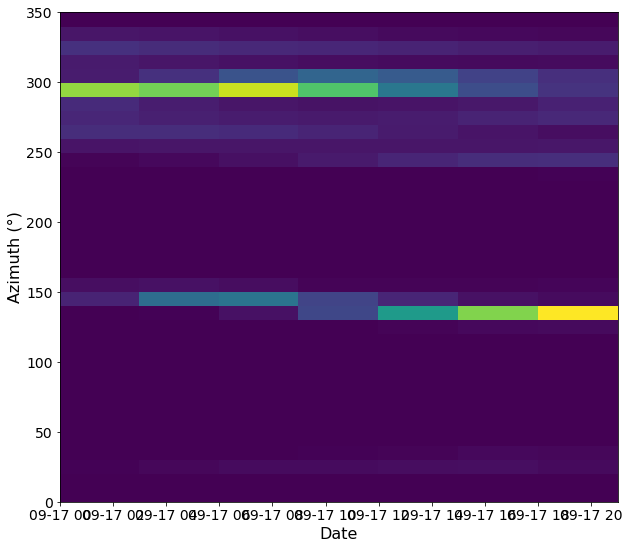

In [7]:
## Plot Azimuth intensity variations in time
plt.figure(figsize=(10,10))
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Azimuth (°)')
plt.pcolor(DATE,azimuth,azi.T)
plt.savefig('azimuth_var_%d_%d.png'%(YEAR, MONTH[0]))

## Plot maximum azimuth intensity in time
plt.figure(figsize=(10,10))
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Azimuth (°)')
plt.plot(DATE,azimuth[np.argmax(azi.T, axis=0)])
plt.savefig('azimuth_max_%d_%d.png'%(YEAR, MONTH[0]))